In [1]:
import itertools
import pandas as pd
from sqlalchemy import create_engine
import pymysql
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import matplotlib.font_manager as fm
from matplotlib import rc
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import sys, os, time
from glob import glob
warnings.filterwarnings(action='ignore')
mpl.rcParams['axes.unicode_minus'] = False
#font_path = 'C:/font/malgun.ttf'
#font_name = fm.FontProperties(fname=font_path).get_name()
#print(font_name)
rc('font', family='AppleGothic')

endpoint = 'dao.c51deksujiip.ap-northeast-2.rds.amazonaws.com'
schema = 'dao'
db_connection_str = 'mysql+pymysql://admin:ekfkawnl@{}/{}'.format(endpoint, schema)
try :
    db_connection = create_engine(db_connection_str)
    conn = db_connection.connect()
except :
    print('fail to connect db')

def load_data_from_rds(tabel_name):
    sql = "SELECT * FROM {}".format(tabel_name)
    df = pd.read_sql(sql, db_connection)
    return df

In [2]:
# sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname(__file__))))

# from preprocessing.preprocessing_func import preprocess_df
def preprocess_df(df, onehot_col=None, scaling_col=None, drop_col = None, labeling_col = None, scaling_func=MinMaxScaler) :
    """
    :param df: 사용할 데이터프레임
    :param onehot_col: default = None, 원핫인코딩할 컬럼 리스트
    :param scaling_col: default = None, 스케일링할 컬럼 리스트
    :param drop_col: default = None, 사용하지 않을 컬럼 리스트
    :param labeling_col: default = None, 라벨링이 필요한 컬럼 리스트
    :param scaling_func: 스케일링시 사용할 컬럼, MinMaxScaler or StandardScaler
    :return: 전처리 된 데이터 프레임
    """
    if drop_col is not None :
        df = df.drop(drop_col, axis=1)
    if onehot_col is not None:
        df = pd.get_dummies(df, colums=onehot_col)
    if scaling_col is not None :
        for c in scaling_col :
            scaler = scaling_func()
            scaler.fit(df[[c]])
            df[c] = scaler.transform(df[[c]])
    if labeling_col is not None :
        for c in labeling_col :
            encoder = LabelEncoder()
            encoder.fit(df[c])
            df[c] = encoder.transform(df[c])
    return df



In [3]:
def plot_confusion_matrix(cm, target_names=None, cmap=None, normalize=True, labels=True, title='Confusion matrix'):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)

    if labels:
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            if normalize:
                plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")
            else:
                plt.text(j, i, "{:,}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [4]:
def random_forest_result(df, file_name, feature_importance = False, optimizing = False):
    train_x, test_x, train_y, test_y = train_test_split(df.drop('생태통로_효율성', axis=1), df['생태통로_효율성'], test_size=0.2, stratify=df['생태통로_효율성'])
    rf_clf = RandomForestClassifier()
    if optimizing :
        parameters = {
            'n_estimators': range(10, 100, 10),
            'max_depth' : range(1, 10, 2),
            'min_samples_split': range(1, 10, 2),
            'min_samples_leaf': [1, 3, 5],
            'random_state' : range(3, 7, 2),
            'criterion' : ['gini', 'entropy']
        }
        start = time.time()
        # Random Forest
        grid_cv = GridSearchCV(rf_clf, param_grid=parameters, n_jobs=-1, scoring='accuracy', cv=5)
        grid_cv.fit(train_x, train_y)
        print('GridSearch 수행시간 : ', time.time()-start)
        print('최적 하이퍼 파라미터 :',grid_cv.best_params_)
        best_cv = grid_cv.best_estimator_

        # GridSearchCV의 최적 하이퍼파라미터로 학습된 Estimator로 예측 및 평가 수행
        pred = best_cv.predict(test_x)
        rf_clf = best_cv
    else:
        rf_clf.fit(train_x, train_y)
        pred = rf_clf.predict(test_x)

    print('정확도 : ', accuracy_score(pred, test_y))
    print('f1 score :', f1_score(y_true=test_y, y_pred=pred, average=None))
    print('f1 score average :', f1_score(y_true=test_y, y_pred=pred, average='macro'))

    # 혼동행렬
    cm =confusion_matrix(test_y, pred)
    plot_confusion_matrix(cm, target_names=list(df['생태통로_효율성'].unique()), cmap='Blues', title='{} confusion matrix'.format(file_name))

    if feature_importance :
        importances = rf_clf.feature_importances_
        std = np.std([tree.feature_importances_ for tree in rf_clf.estimators_], axis=0)
        indices = np.argsort(importances)[::-1]

        print('Feature Ranking:')
        for f in range(train_x.shape[1]) :
            print('{}. feature {} ({:3f})'.format(f+1, train_x.columns[indices][f], importances[indices[f]]))
            if f == 10 :
                break

        plt.title('Feature importances')
        plt.bar(range(train_x.shape[1]), importances[indices],
                color='r', yerr=std[indices])
        plt.xlim([-1, train_x.shape[1]])
        plt.xticks(rotation=45)
        plt.show()

In [5]:
overpass_list = glob('.././data/*overpass*.csv')
#overpass_list = [p.replace('\\', '/') for p in overpass_list]
print(overpass_list)
tunnel_list = glob('.././data/*tunnel*.csv')
#tunnel_list = [p.replace('\\', '/') for p in tunnel_list]
print(tunnel_list)

['.././data/overpass_knn2_median.csv', '.././data/overpass_mean_drop.csv', '.././data/overpass_knn1_drop.csv', '.././data/overpass_knn5_median.csv', '.././data/overpass_mean_median.csv', '.././data/overpass_knn3_median.csv', '.././data/overpass_knn2_drop.csv', '.././data/overpass_knn3_drop.csv', '.././data/overpass_knn5_drop.csv', '.././data/overpass_knn4_drop.csv', '.././data/overpass_knn4_median.csv', '.././data/overpass_knn1_median.csv']
['.././data/tunnel_knn1_drop.csv', '.././data/tunnel_mean_drop.csv', '.././data/tunnel_knn2_median.csv', '.././data/tunnel_knn5_median.csv', '.././data/tunnel_knn3_median.csv', '.././data/tunnel_knn2_drop.csv', '.././data/tunnel_knn3_drop.csv', '.././data/tunnel_mean_median.csv', '.././data/tunnel_knn1_median.csv', '.././data/tunnel_knn4_median.csv', '.././data/tunnel_knn5_drop.csv', '.././data/tunnel_knn4_drop.csv']


In [8]:
onehot_col = ['지형기호(2.3km)', '최우점식물군락']
scaling_col = ['폭(m)', '연장(m)', '주변 로드킬 빈도', '산책로까지의 최단 거리(km)', '농가까지의 거리(km)', '도로 최고제한속도(km/h)',
               '하천거리(km)', '주변 동물종 개수', '등산로까지 최단거리(km)', '유도울타리_연장_m', '유도울타리_높이_m', '교통량', 
               '건물까지거리(km)', '주변동물 출현빈도']
drop_col = ['번호', '위도', '경도', '생태통로_유형', '이용확인종_수', '유도울타리_위도_2.3km', '유도울타리_경도_2.3km', '식물군락명']
scaling_col_tunnel = scaling_col + ['높이(m)', '개방도']

# 육교형

GridSearch 수행시간 :  37.98927879333496
최적 하이퍼 파라미터 : {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 10, 'random_state': 3}
정확도 :  0.6166666666666667
f1 score : [0.44444444 0.75       0.5       ]
f1 score average : 0.5648148148148149


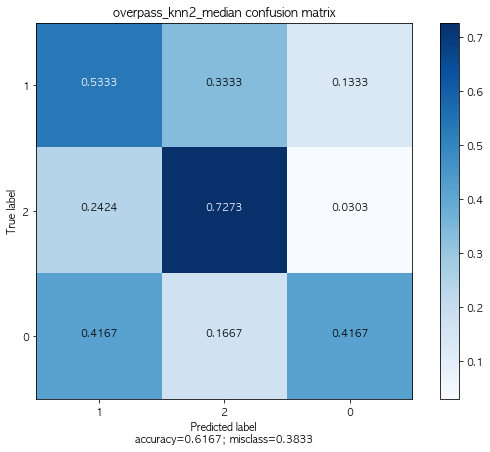

GridSearch 수행시간 :  36.74674701690674
최적 하이퍼 파라미터 : {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 30, 'random_state': 5}
정확도 :  0.35135135135135137
f1 score : [0.56410256 0.         0.19047619]
f1 score average : 0.2515262515262515


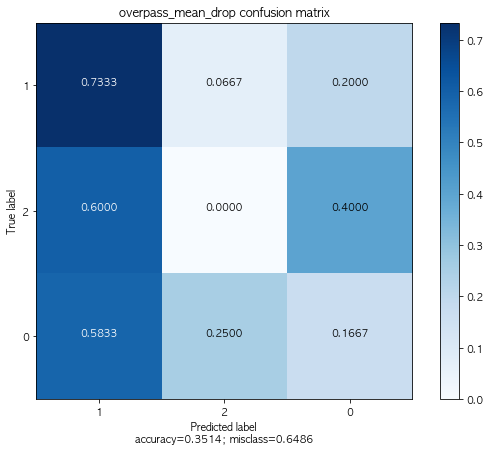

GridSearch 수행시간 :  36.89036798477173
최적 하이퍼 파라미터 : {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 50, 'random_state': 5}
정확도 :  0.2702702702702703
f1 score : [0.43902439 0.13333333 0.        ]
f1 score average : 0.1907859078590786


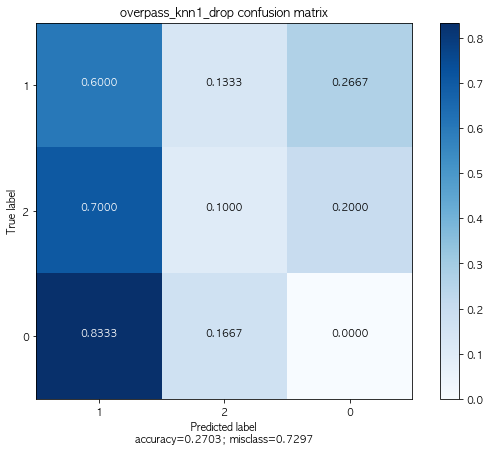

GridSearch 수행시간 :  37.69579792022705
최적 하이퍼 파라미터 : {'criterion': 'entropy', 'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 20, 'random_state': 5}
정확도 :  0.6666666666666666
f1 score : [0.38709677 0.82539683 0.61538462]
f1 score average : 0.6092927383249963


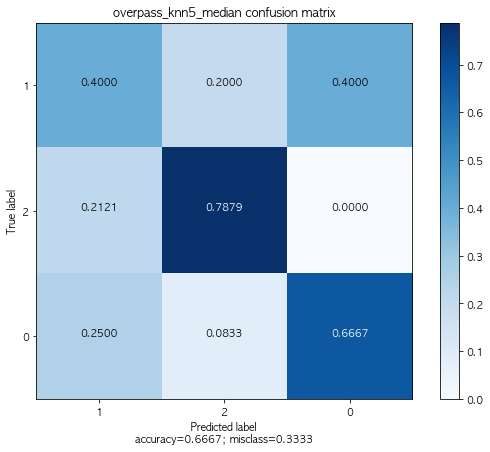

GridSearch 수행시간 :  38.076783895492554
최적 하이퍼 파라미터 : {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 9, 'n_estimators': 40, 'random_state': 3}
정확도 :  0.6833333333333333
f1 score : [0.61111111 0.83333333 0.41666667]
f1 score average : 0.6203703703703703


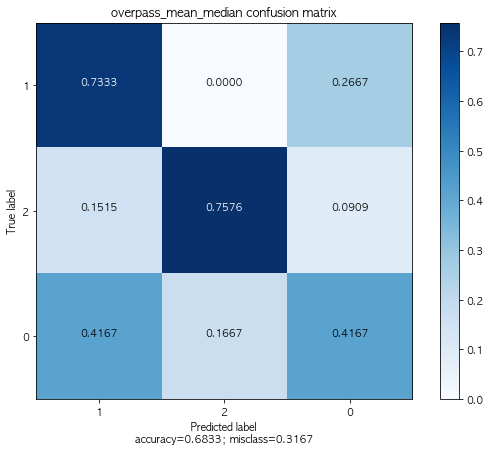

GridSearch 수행시간 :  38.02941536903381
최적 하이퍼 파라미터 : {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 80, 'random_state': 3}
정확도 :  0.6666666666666666
f1 score : [0.52380952 0.86666667 0.33333333]
f1 score average : 0.5746031746031746


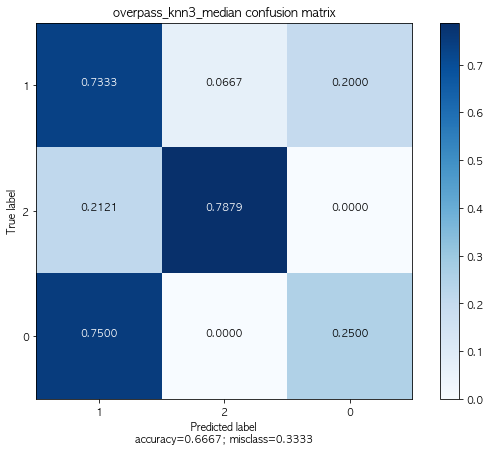

GridSearch 수행시간 :  37.7260160446167
최적 하이퍼 파라미터 : {'criterion': 'entropy', 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 10, 'random_state': 3}
정확도 :  0.43243243243243246
f1 score : [0.58823529 0.         0.15384615]
f1 score average : 0.2473604826546003


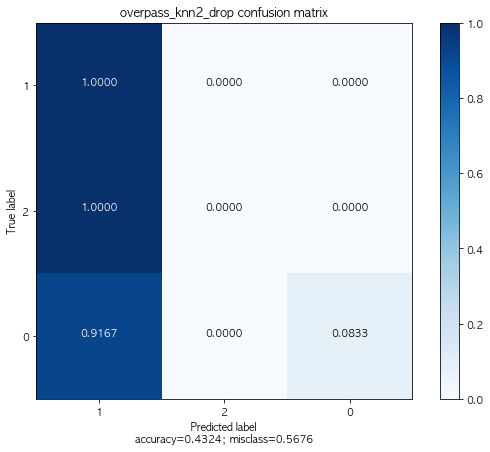

GridSearch 수행시간 :  37.58440017700195
최적 하이퍼 파라미터 : {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 20, 'random_state': 3}
정확도 :  0.3783783783783784
f1 score : [0.5106383  0.         0.26666667]
f1 score average : 0.2591016548463357


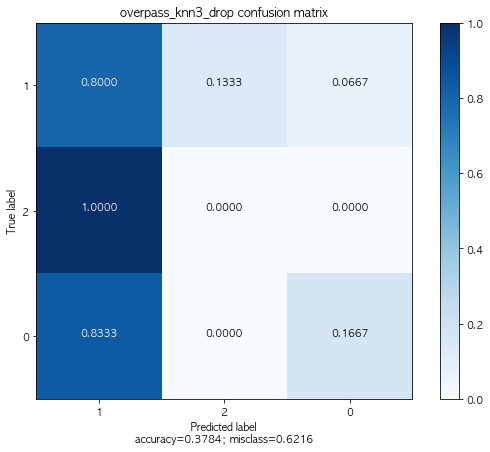

GridSearch 수행시간 :  37.54533624649048
최적 하이퍼 파라미터 : {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 20, 'random_state': 3}
정확도 :  0.40540540540540543
f1 score : [0.5        0.25       0.33333333]
f1 score average : 0.3611111111111111


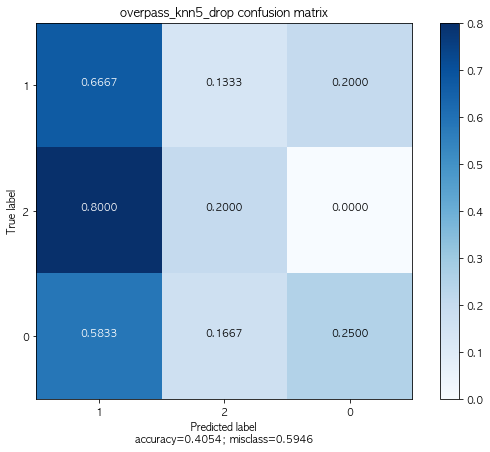

GridSearch 수행시간 :  37.917237997055054
최적 하이퍼 파라미터 : {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 3, 'min_samples_split': 7, 'n_estimators': 40, 'random_state': 5}
정확도 :  0.4594594594594595
f1 score : [0.56410256 0.28571429 0.38095238]
f1 score average : 0.4102564102564103


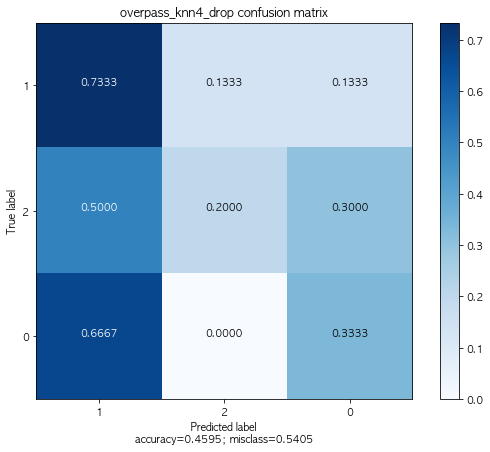

GridSearch 수행시간 :  38.911962270736694
최적 하이퍼 파라미터 : {'criterion': 'entropy', 'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 40, 'random_state': 3}
정확도 :  0.5833333333333334
f1 score : [0.3030303  0.8115942  0.22222222]
f1 score average : 0.4456155760503586


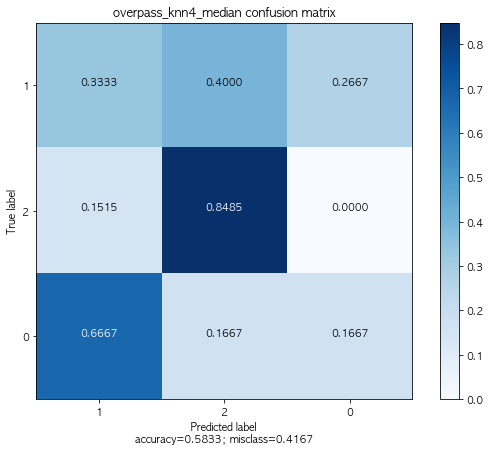

GridSearch 수행시간 :  38.29707980155945
최적 하이퍼 파라미터 : {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 3, 'min_samples_split': 7, 'n_estimators': 10, 'random_state': 3}
정확도 :  0.6
f1 score : [0.25806452 0.78688525 0.57142857]
f1 score average : 0.5387927778197478


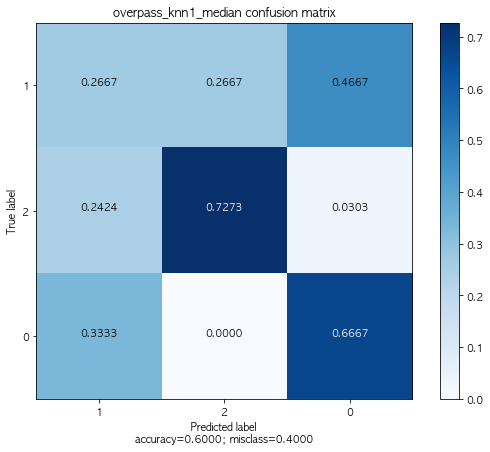

In [9]:
for case in overpass_list :
    df = pd.read_csv(case, encoding='cp949')
    name = case.split('/')[-1].split('.')[0]
    # print(df.columns)
    df = preprocess_df(df, drop_col=drop_col, labeling_col=onehot_col, scaling_col=scaling_col, scaling_func=StandardScaler)
    # print(df.columns)
    random_forest_result(df, file_name=name, optimizing=True)


# 터널형

GridSearch 수행시간 :  36.464420795440674
최적 하이퍼 파라미터 : {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 3, 'min_samples_split': 7, 'n_estimators': 20, 'random_state': 3}
정확도 :  0.52
f1 score : [0.57142857 0.28571429 0.54545455]
f1 score average : 0.4675324675324675


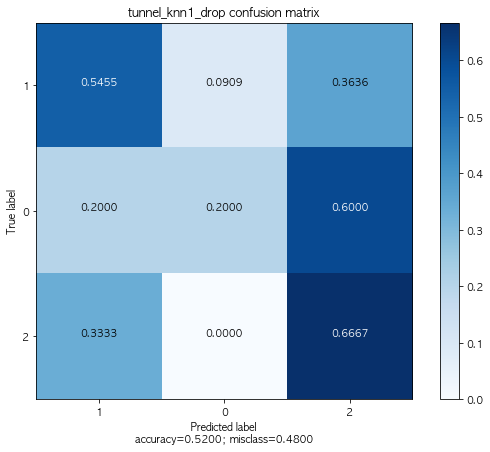

GridSearch 수행시간 :  36.83632278442383
최적 하이퍼 파라미터 : {'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 30, 'random_state': 5}
정확도 :  0.6
f1 score : [0.63636364 0.         0.72727273]
f1 score average : 0.4545454545454546


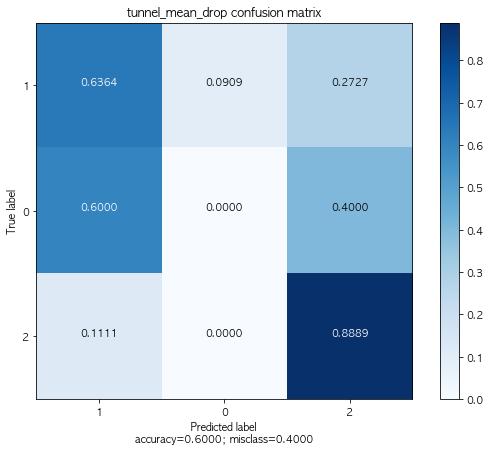

GridSearch 수행시간 :  36.83809685707092
최적 하이퍼 파라미터 : {'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 90, 'random_state': 5}
정확도 :  0.875
f1 score : [0.81481481 0.91891892 0.875     ]
f1 score average : 0.869577911244578


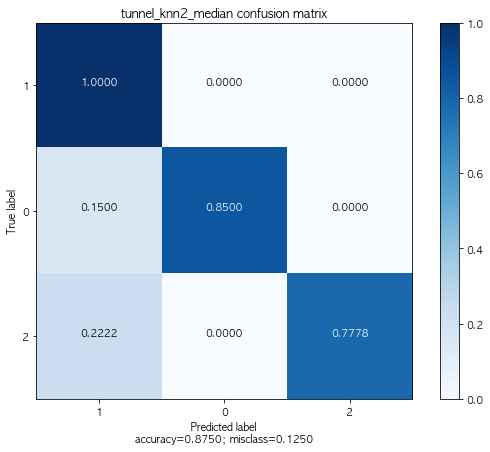

GridSearch 수행시간 :  36.59614419937134
최적 하이퍼 파라미터 : {'criterion': 'entropy', 'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 20, 'random_state': 5}
정확도 :  0.95
f1 score : [0.91666667 1.         0.875     ]
f1 score average : 0.9305555555555555


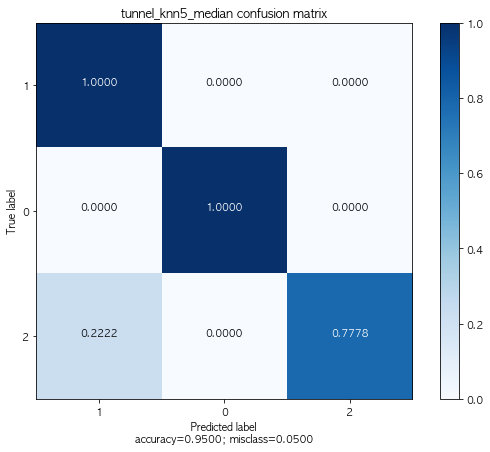

GridSearch 수행시간 :  36.437785148620605
최적 하이퍼 파라미터 : {'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 9, 'n_estimators': 60, 'random_state': 3}
정확도 :  0.775
f1 score : [0.68965517 0.86486486 0.71428571]
f1 score average : 0.7562685838547908


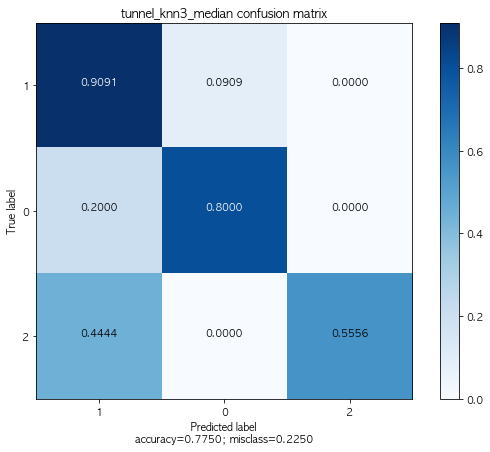

GridSearch 수행시간 :  35.95760989189148
최적 하이퍼 파라미터 : {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 80, 'random_state': 3}
정확도 :  0.6
f1 score : [0.63157895 0.28571429 0.66666667]
f1 score average : 0.5279866332497912


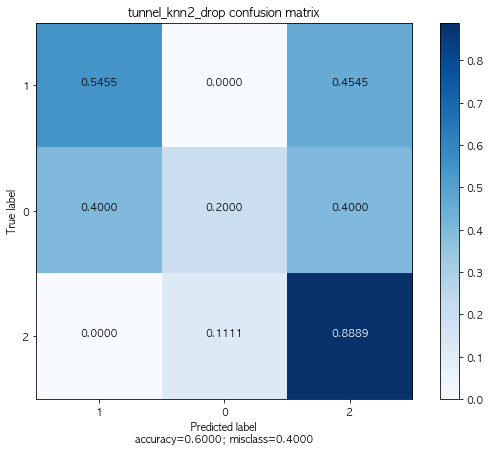

GridSearch 수행시간 :  36.118457078933716
최적 하이퍼 파라미터 : {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 20, 'random_state': 3}
정확도 :  0.56
f1 score : [0.60869565 0.36363636 0.625     ]
f1 score average : 0.5324440052700923


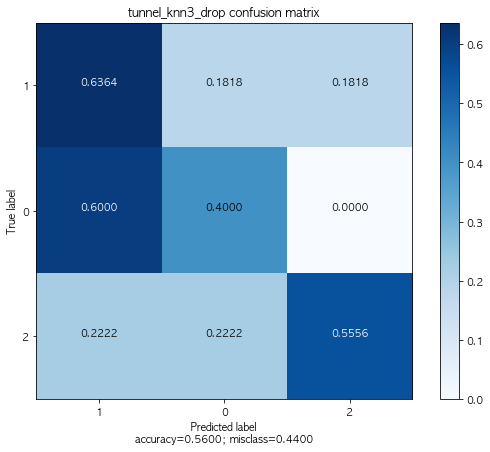

GridSearch 수행시간 :  35.89907503128052
최적 하이퍼 파라미터 : {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 40, 'random_state': 5}
정확도 :  0.75
f1 score : [0.64       0.92307692 0.5       ]
f1 score average : 0.6876923076923077


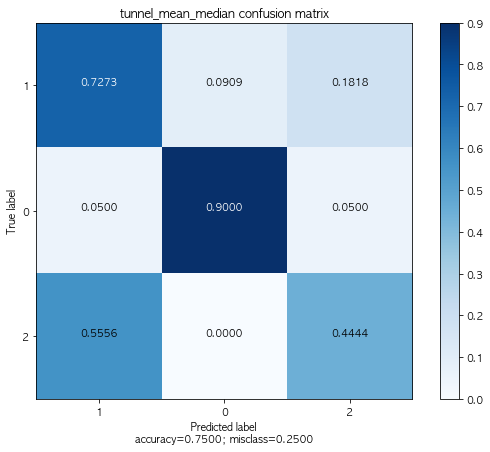

GridSearch 수행시간 :  34.77992510795593
최적 하이퍼 파라미터 : {'criterion': 'entropy', 'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 80, 'random_state': 5}
정확도 :  0.7
f1 score : [0.64       0.87804878 0.28571429]
f1 score average : 0.6012543554006968


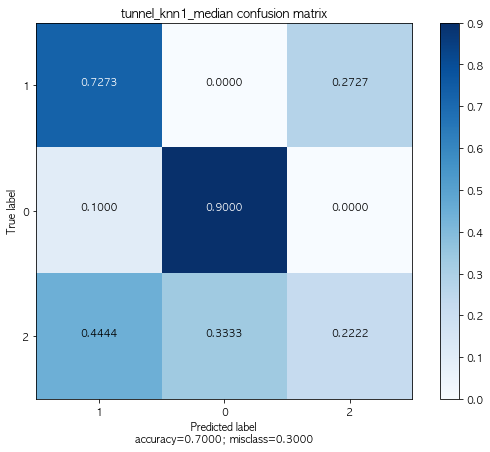

GridSearch 수행시간 :  34.86364197731018
최적 하이퍼 파라미터 : {'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 40, 'random_state': 5}
정확도 :  0.75
f1 score : [0.64285714 0.85714286 0.70588235]
f1 score average : 0.7352941176470589


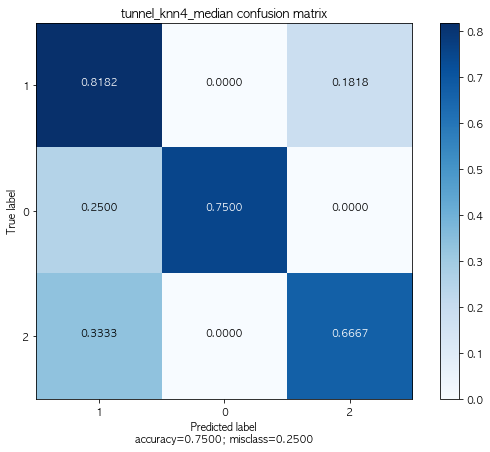

GridSearch 수행시간 :  35.30069088935852
최적 하이퍼 파라미터 : {'criterion': 'entropy', 'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 20, 'random_state': 3}
정확도 :  0.76
f1 score : [0.86956522 0.5        0.73684211]
f1 score average : 0.7021357742181541


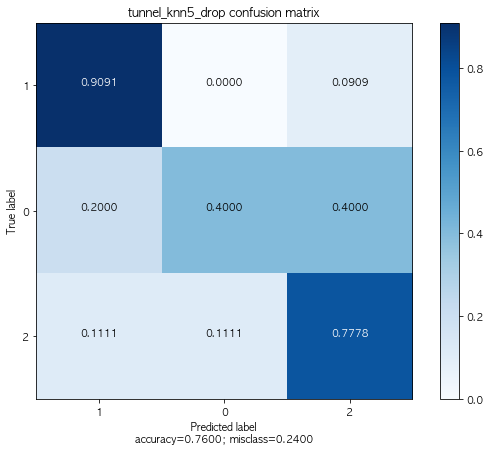

GridSearch 수행시간 :  35.92823672294617
최적 하이퍼 파라미터 : {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 90, 'random_state': 3}
정확도 :  0.64
f1 score : [0.69230769 0.         0.77777778]
f1 score average : 0.4900284900284901


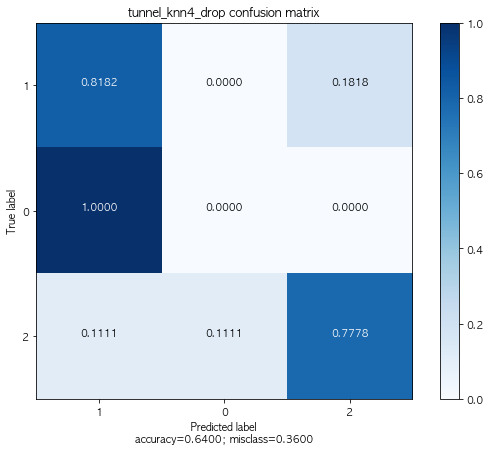

In [10]:
for case in tunnel_list :
    df = pd.read_csv(case, encoding='cp949')
    name = case.split('/')[-1].split('.')[0]
    # print(df.columns)
    df = preprocess_df(df, drop_col=drop_col, labeling_col=onehot_col, scaling_col=scaling_col_tunnel, scaling_func=StandardScaler)
    # print(df.columns)
    random_forest_result(df, file_name=name, optimizing=True)
